# Explaining the values 

In [1]:
import sys
import os
sys.path.append('../workspace/src/')

In [2]:
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_batch, to_scipy_sparse_matrix, scatter

In [3]:
from pair_graphs import InferenceDataset, collate_batch, PairDataset
from multimodal_attention_network_exp import NodeImpor, NodeRank

import pandas as pd
import umap
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
from rdkit import Chem, DataStructs
from scipy import stats
from scipy.spatial.distance import pdist,squareform
from train_drp import MultimodalAttentionNet, Conf
import torch
from multimodal_attention_network_exp import GAT
from torch.utils.data import DataLoader


/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [4]:
import numpy as np
from scipy.sparse import csc_matrix
from create_graphs_ppi import PPIGraphsL1000, PPIGraphsDRP
from tqdm import tqdm
%matplotlib inline

In [32]:
device = 'cpu'
gat = GAT(dim_in=5).to(device)
project_dir = Path('/workspace')
processed_dir = project_dir / 'data/processed/'
raw_dir = project_dir / 'data/raw/'
ppi = PPIGraphsDRP(project_dir)

In [6]:
class DatasetTest(torch.utils.data.Dataset):
    def __init__(self, labels_path: str = 'DRP',
                 problem: str ='regression', 
                 self_att: str = '', root: str = '/workspace'):
        self.problem = problem
        self.self_att = self_att
        self.root = root
        # self.root = Path(__file__).resolve().parents[1].absolute()
        # print(self.root)
        if 'DRP' in str(labels_path):
            # self.molecular_graphs = MolecularGraphs(self.root )
            self.ppi_graphs = PPIGraphsDRP(self.root, self_att=self_att )
        
        """for ppi_graph in self.ppi_graphs:
                cell_index.append(i)
                cellosaurus_accession.append(ppi_graph.cell_name)
                i += 1
        self.cell_indices = pd.Series(data=cell_index, index=cellosaurus_accession)
        """ 
        l= [i for i in range(len(self.ppi_graphs))]
        self.cell_indices = pd.Series(data=l, index=l)

    def __len__(self):
        return len(self.ppi_graphs)
    
    def __getitem__(self, idx):
        ppi_graph_idx = self.cell_indices[idx]	
        return self.ppi_graphs[ppi_graph_idx.tolist()]
    
    def pin_memory(self):
        return True

def collate_test(batch):
    batchB = Batch.from_data_list([data for data in batch])
    return batchB

In [7]:
ppi = DatasetTest()
dataloader = DataLoader(ppi, batch_size=10, shuffle=False, collate_fn=collate_test)

## Draw the attention of protein nodes
The experiment named 'epoch=212-step=1957470.ckpt'

In [8]:
att_df = pd.read_csv(processed_dir / 
        'NCI60DRP_random_self_att/attentionDRP.csv', index_col=0)
cells = att_df['cell'].unique()
att_df
e1 = att_df.loc[att_df['cell'] == 'CVCL_0292']['protein_1'].values
e2 = att_df.loc[att_df['cell'] == 'CVCL_0292']['protein_2'].values
edge_index = np.vstack((e1, e2))
att_ppi = torch.tensor(att_df.loc[att_df['cell'] == 
                        'CVCL_0292']['attention'].values).to(device)
att_ppi = att_ppi.double()
edge_index = torch.tensor(edge_index)
edge_index = edge_index.to(device)
nul_tensor = torch.zeros(len(att_df.loc[att_df['cell'] == 
                        'CVCL_0292']['protein_1'].unique()), dtype=torch.int64)
nul_tensor = nul_tensor.to(device)
batch_att_scipy = torch.sparse_coo_tensor(edge_index,
                                         att_ppi).double()
batch_att_scipy.shape
print('sum scatter along dim 0', scatter(att_ppi, edge_index[0], 
                                         dim=0, reduce='sum').squeeze())
print('sum attentions by node 2', att_ppi[edge_index[0] == 2].sum())

sum scatter along dim 0 tensor([17.3943,  1.1438,  7.7983,  ...,  6.7341, 16.7797,  3.7958],
       dtype=torch.float64)
sum attentions by node 2 tensor(7.7983, dtype=torch.float64)


In [9]:
# Create Page Rank Node Imporatance from attention matrix
def make_node_importance(att_df, device, cell):
    e1 = att_df.loc[att_df['cell'] == cell]['protein_1'].values
    e2 = att_df.loc[att_df['cell'] == cell]['protein_2'].values
    edge_index = np.vstack((e1, e2))
    att_ppi = torch.tensor(att_df.loc[att_df['cell'] == cell]['attention'].values).to(device)
    att_ppi = att_ppi.double()
    edge_index = torch.tensor(edge_index)
    edge_index = edge_index.to(device)
    nul_tensor = torch.zeros(len(att_df.loc[att_df['cell'] == cell]['protein_1'].unique()), dtype=torch.int64)
    nul_tensor = nul_tensor.to(device)
    batch_att_scipy = torch.sparse_coo_tensor(edge_index,
                                         att_ppi).double()
    att_ppi = att_ppi.unsqueeze(-1) # shape (B, |E|) - > (B, |E|, 1)
    # Use torch.bincount() to count the occurrences of each unique number
    torch.use_deterministic_algorithms(False)
    counts = torch.bincount(nul_tensor).to(device)
    # Calculate inverted counts
    inverted_counts =  1 / counts
    # Use torch.gather() to invert the counts for each node in the batch
    x0 = torch.gather(inverted_counts, 0, nul_tensor).unsqueeze(-1).double()
    # Create a diagonal matrix from the inverted counts
    diag = 1 / scatter(att_ppi, edge_index[0], dim=0, reduce='sum').squeeze()
    diag_inv = torch.diag(diag).to(device).double()

    a = torch.sparse.mm(batch_att_scipy, diag_inv)
    a = a.to_sparse()
    use_tqdm = True
    #progress = tqdm(range(100), unit_scale=True, 
    #                    leave=False, disable=not use_tqdm)
    d = 0.85
    ep = x0
    epsilon = 1e-6
    for i in range(1000):
        ep_old = ep
        # dense matrix to be added, sparse matrix to be multiplied, 
        # dense matrix to be multiplied, multiplier for added matrix, 
        # multiplier for product
        ep = torch.sparse.addmm(x0, a, ep, beta=1-d, alpha=d) 
        diff = torch.linalg.norm(ep - ep_old, ord=float("+inf"), axis=0)
        if (diff < epsilon).all():
            break
        mask = diff > epsilon

    print(f"Converged after {i} iterations up to {epsilon}.")
    return ep

In [10]:
def ni_to_df(att_df, cells, device):
    ni = []
    att_df = att_df.sort_values(by=['cell'])
    for cell in cells:
        ep = make_node_importance(att_df, device, cell)
        ni.append(ep)
    ni = torch.vstack(ni).detach().cpu().numpy()
    print('shape of node importances stacked', ni.shape)
    att_importance_nodes = att_df[['protein_1', 'p1_name', 'cell']].drop_duplicates().sort_values([ 'cell','protein_1'], ascending=[True, True])
    att_importance_nodes['node_importance'] = ni
    # att_importance_nodes.to_csv(processed_dir / 'NCI60DRPApr_random/att_importance_nodes.csv')
node_importance = pd.read_csv(processed_dir / 
    'NCI60DRPApr_random/att_importance_nodes.csv', index_col=0)
node_importance.head()

,protein_1,p1_name,cell,node_importance
394,0,ABCA13,CVCL_0004,0.000974
21,1,ACADL,CVCL_0004,0.000089
393,2,AFAP1,CVCL_0004,0.000400
291,3,AGO4,CVCL_0004,0.000988
254,4,AGT,CVCL_0004,0.000131


In [35]:
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go
import plotly.offline as pyo
import json

In [12]:
att_df['cell'].unique()

array(['CVCL_0292', 'CVCL_1331', 'CVCL_1779', 'CVCL_1304', 'CVCL_1690',
       'CVCL_1092', 'CVCL_0021', 'CVCL_0062', 'CVCL_1195', 'CVCL_1051',
       'CVCL_0004'], dtype=object)

In [13]:
att_df.groupby('cell').count()

,attention,protein_1,protein_2,p1_name,p2_name
cell,,,,,
CVCL_0004,567,567,567,567,567
CVCL_0021,244,244,244,244,244
CVCL_0062,1120,1120,1120,1120,1120
CVCL_0292,102213,102213,102213,102213,102213
CVCL_1051,651,651,651,651,651
CVCL_1092,291,291,291,291,291
CVCL_1195,785,785,785,785,785
CVCL_1304,29218,29218,29218,29218,29218
CVCL_1331,33595,33595,33595,33595,33595


<AxesSubplot: xlabel='node_importance', ylabel='Count'>

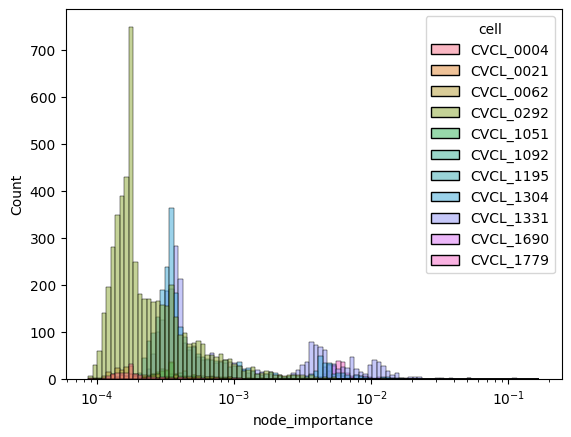

In [14]:
sns.histplot(node_importance, x='node_importance', hue='cell', bins=100, 
             log_scale=True)

<AxesSubplot: xlabel='attention', ylabel='Count'>

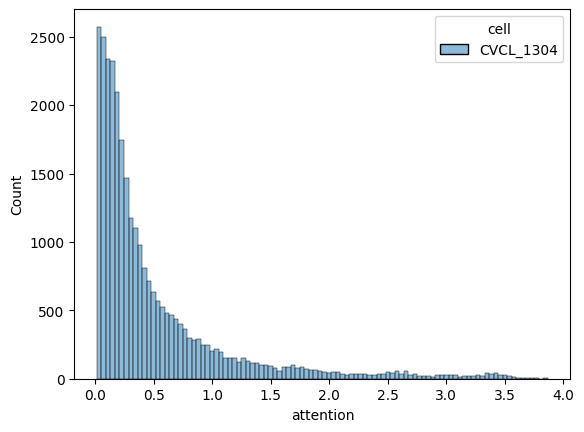

In [15]:
cvcl_1304 = att_df[att_df['cell'].str.contains('CVCL_1304')]
sns.histplot(cvcl_1304, x='attention', hue='cell', bins=100)

In [16]:
att_df['cell'].unique()

array(['CVCL_0292', 'CVCL_1331', 'CVCL_1779', 'CVCL_1304', 'CVCL_1690',
       'CVCL_1092', 'CVCL_0021', 'CVCL_0062', 'CVCL_1195', 'CVCL_1051',
       'CVCL_0004'], dtype=object)

In [50]:
att_df[att_df['cell'].isin(['CVCL_0292'])]

,attention,protein_1,protein_2,cell,p1_name,p2_name
0,0.874169,2960,205,CVCL_0292,NDUFAF7,ALX3
1,3.446285,2960,4455,CVCL_0292,NDUFAF7,ST3GAL5
2,1.082615,2960,5346,CVCL_0292,NDUFAF7,ZNF517
3,0.111544,2960,2819,CVCL_0292,NDUFAF7,MTRF1
4,0.073360,2960,2493,CVCL_0292,NDUFAF7,LONP1
...,...,...,...,...,...,...
102208,0.247834,5426,5426,CVCL_0292,ZW10,ZW10
102209,2.414122,5427,5427,CVCL_0292,ZYG11A,ZYG11A
102210,0.527939,5428,5428,CVCL_0292,ZYG11B,ZYG11B
102211,0.113527,5429,5429,CVCL_0292,ZYX,ZYX


<AxesSubplot: xlabel='attention', ylabel='Count'>

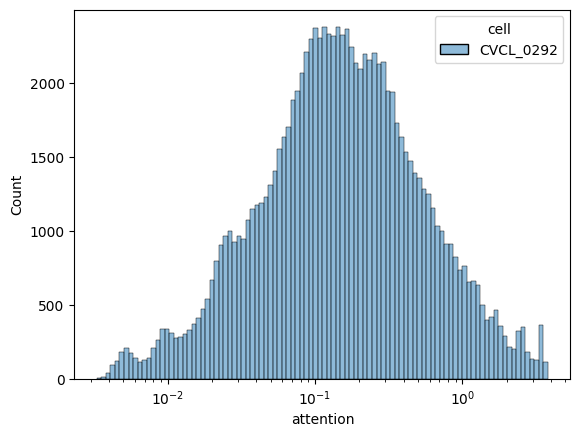

In [17]:
sns.histplot(att_df[att_df['cell'].isin(['CVCL_0292'])], x='attention', hue='cell', bins=100, 
             log_scale=True)

<AxesSubplot: xlabel='attention', ylabel='Count'>

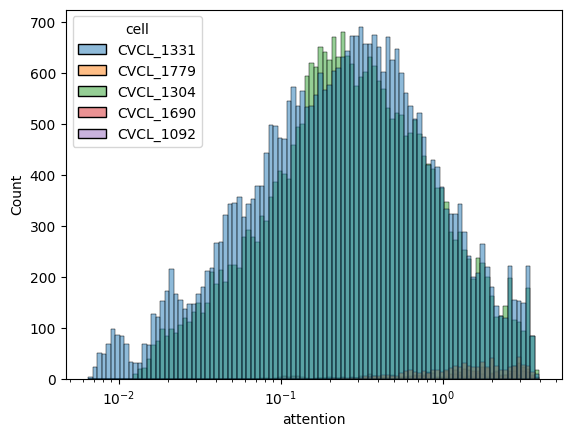

In [18]:
at1 = att_df[att_df['cell'].isin(['CVCL_1331', 'CVCL_1779', 'CVCL_1304', 'CVCL_1690',
       'CVCL_1092'])]
at2 = att_df[att_df['cell'].isin(['CVCL_0021', 'CVCL_0062', 'CVCL_1195', 'CVCL_1051',
       'CVCL_0004'])]

sns.histplot(at1, x='attention', hue='cell', bins=100, 
             log_scale=True)

<AxesSubplot: xlabel='attention', ylabel='Count'>

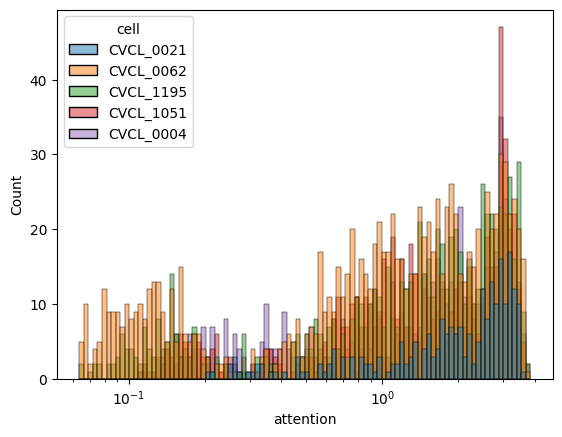

In [19]:
sns.histplot(at2, x='attention', hue='cell', bins=100, 
             log_scale=True)

In [20]:
cvcl_1304_05 = cvcl_1304[cvcl_1304['attention'] > 0.5]
cvcl_1304_05

,attention,protein_1,protein_2,cell,p1_name,p2_name
1,0.858900,1199,478,CVCL_1304,M6PR,COMT
2,0.891869,1199,193,CVCL_1304,M6PR,ATP4A
9,1.347847,2308,689,CVCL_1304,USP28,ESPL1
14,2.694633,2308,2315,CVCL_1304,USP28,USP51
16,1.099197,2308,2286,CVCL_1304,USP28,UCK1
...,...,...,...,...,...,...
29213,0.696590,2467,2467,CVCL_1304,ZSCAN21,ZSCAN21
29214,0.583820,2468,2468,CVCL_1304,ZSCAN32,ZSCAN32
29215,1.303613,2469,2469,CVCL_1304,ZSCAN4,ZSCAN4
29216,1.658095,2470,2470,CVCL_1304,ZSWIM6,ZSWIM6


In [21]:
cvcl_1304_ = cvcl_1304[(cvcl_1304['p2_name'].isin(['PTEN', 'AXIN1'])) | (cvcl_1304['p1_name'].isin(['PTEN', 'AXIN1']))]
#cvcl_1304_ = cvcl_1304[cvcl_1304['p2_name'].isin(['PTEN', 'AXIN1'])]

cvcl_1304_

,attention,protein_1,protein_2,cell,p1_name,p2_name
27,0.181786,622,204,CVCL_1304,DVL2,AXIN1
107,0.064422,1634,1675,CVCL_1304,PPP5C,PTEN
198,0.185125,2372,204,CVCL_1304,YTHDC2,AXIN1
287,0.059241,907,1675,CVCL_1304,HEATR6,PTEN
757,0.059841,638,1675,CVCL_1304,EEF1A2,PTEN
...,...,...,...,...,...,...
26317,0.044701,785,1675,CVCL_1304,FRK,PTEN
26624,0.064104,20,1675,CVCL_1304,ACACA,PTEN
26730,0.038159,1981,1675,CVCL_1304,SMTN,PTEN
26950,0.186822,204,204,CVCL_1304,AXIN1,AXIN1


In [25]:
raw_dir / 'KEGG/biological_processes{}.json'

PosixPath('/data/raw/KEGG/biological_processes{}.json')

In [44]:
from bioservices import KEGG
import json
def retrieve_kegg_biological_processes(gene_names, cell):
    if os.path.exists(raw_dir / 'KEGG/biological_processes{}.json'.format(cell)):
        with open(raw_dir / 'KEGG/biological_processes{}.json'.format(cell)) as json_file:
            ret = json.load(json_file)
        return ret
    
    kegg = KEGG()

    # Return biological processes as dictionary with gene names as keys
    biological_processes = {}

    for gene_name in gene_names:
        try:
            # Search for the gene name in KEGG
            result = kegg.get_pathway_by_gene(gene=gene_name, organism="hsa")
            biological_processes[gene_name] = result
        except:
            biological_processes[gene_name] = []
    with open(raw_dir / 'KEGG/biological_processes{}.json'.format(cell), 'w') as fp:
        json.dump(biological_processes, fp)
    return biological_processes

# Example usage
gene_names = cvcl_1304_05['p2_name'].unique().tolist()
processes_1304 = retrieve_kegg_biological_processes(gene_names, 'CVCL_1304')

In [39]:
# Write a function to prepaer df file from processes data
def prepare_df(processes):
    df = pd.DataFrame.from_dict(processes)
    df = df.melt(var_name='gene_name', value_name='biological_processes'
                 ).drop_duplicates().dropna().reset_index(drop=True)

    df = df[df['biological_processes'].str.contains('pathway|signal')
            ].reset_index(drop=True)
    
    df = df.drop_duplicates(subset=['gene_name'])
    df = df.dropna().reset_index(drop=True)
    # Retain rows with 'path' or 'signal' in the biological processes
    df = df[df['biological_processes'].str.contains('path|signal')
            ].reset_index(drop=True)
    # Remove rows with only one entry in biological processes
    df = df.groupby('biological_processes').filter(lambda x: len(x) > 5
                                                ).reset_index(drop=True)
    df.groupby('biological_processes')['gene_name'].count().sort_values(ascending=False)
    df = df.drop_duplicates(subset='gene_name')
    df = df.sort_values(by='biological_processes').reset_index(drop=True)
    df.head()
    return df

df = prepare_df(processes_1304)
df.head()

,gene_name,biological_processes
0,MST1R,Calcium signaling pathway
1,PHKB,Calcium signaling pathway
2,LHCGR,Calcium signaling pathway
3,RYR3,Calcium signaling pathway
4,RYR1,Calcium signaling pathway


In [40]:
# Write function to prepare cell line data
def prepare_cell_line_data(df, att_df, cell_line, node_importance):
    nod_cvcl = node_importance[node_importance['cell'] == cell_line]
    nod_cvcl = nod_cvcl[['p1_name', 'node_importance']]
    nod_cvcl = nod_cvcl.rename(columns={'p1_name': 'node'})
    cell_line = att_df[att_df['cell'] == cell_line]
    data = cell_line[(cell_line['p2_name'].isin(df['gene_name'])) & 
                    (cell_line['p1_name'].isin(df['gene_name']))
                    ].drop_duplicates().reset_index(drop=True)
    
    data = data.merge(df, left_on='p2_name', right_on='gene_name', 
                      how='left').dropna().reset_index(drop=True)
    
    data = data.merge(nod_cvcl, left_on='p2_name', right_on='node',
                      how='left')

    # Drop biological proceses with less than 2 genes
    data = data.groupby('biological_processes').filter(
        lambda x: len(x) > 1).reset_index(drop=True)

    return data

data = prepare_cell_line_data(df, att_df, 'CVCL_1304', node_importance)
data.drop_duplicates()
data.head()

,attention,protein_1,protein_2,cell,p1_name,p2_name,gene_name,biological_processes,node,node_importance
0,1.090049,1344,85,CVCL_1304,NANS,AKR1A1,AKR1A1,Metabolic pathways,AKR1A1,0.000305
1,0.852296,1344,946,CVCL_1304,NANS,HPRT1,HPRT1,Metabolic pathways,HPRT1,0.000425
2,0.685450,1220,1224,CVCL_1304,MAPK12,MAPKAPK5,MAPKAPK5,MAPK signaling pathway,MAPKAPK5,0.001099
3,1.287982,1463,502,CVCL_1304,PAPOLA,CSTF2T,CSTF2T,mRNA surveillance pathway,CSTF2T,0.000225
4,0.628168,1463,488,CVCL_1304,PAPOLA,CPSF2,CPSF2,mRNA surveillance pathway,CPSF2,0.000719


In [42]:
sel_genes = pd.read_csv('workspace/data/raw/NCI60June2022/nci60_selection_marker_genes.csv')

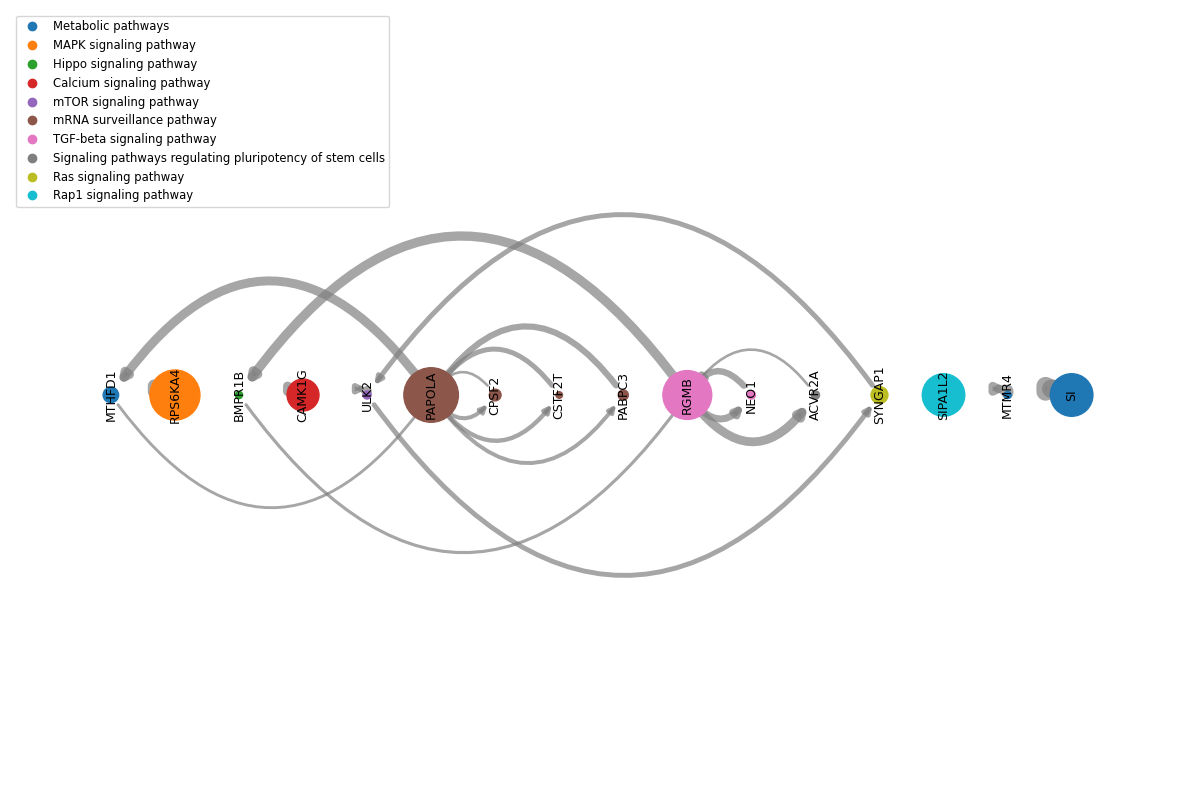

In [41]:
def plot_cell_line_graph(cvcl_name, node_importance, data, gene_list):
    nod_cvcl = node_importance[node_importance['cell'] == cvcl_name]
    nod_cvcl = nod_cvcl[['p1_name', 'node_importance']]
    nod_cvcl = nod_cvcl.rename(columns={'p1_name': 'node'})

    data_ = data[( data['p2_name'].isin(gene_list)| data['p1_name'].isin(gene_list))]
    data_ = data_.sort_values(by='biological_processes', ascending=False) 
    data_ = pd.concat([data_.iloc[-4:], data_.iloc[:-4]], axis=0)
    data_ = data_.merge(nod_cvcl, left_on='p2_name', right_on='node', how='left')
    # Sample node data with class information
    #nodes = data_['p2_name'].unique()
    nodes = data_['p2_name'].unique()
    classes = data_['biological_processes'].unique()
    
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)

    # Add edges to the graph
    edges = data_[['p2_name', 'p1_name']].values.tolist()  # Specify the edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    # Draw the graph
    plt.figure(figsize=(15, 10))
    # Sort nodes based on class
    #nodes_sorted = sorted(nodes, key=lambda node: data_.loc[data_['p2_name'] == node, 'biological_processes'].values[0], reverse=True)
    nodes_sorted = data_['p2_name'].unique().tolist()
    # Specify the positions of the nodes on a line with increased spacing
    node_spacing = 2  # Adjust the spacing between nodes
    node_positions = {node: (i * node_spacing, 0) for i, node in enumerate(nodes_sorted)}
    # Generate class colors automatically
    num_classes = len(classes)
    palette = sns.color_palette('tab10', num_classes)
    class_colors = {cls: color for cls, color in zip(classes, palette)}

    # Create a list of node colors based on classes
    node_colors = [class_colors[data_.loc[data_['p2_name'] == node, 'biological_processes'].values[0]] for node in nodes_sorted]

    # Create a list of node sizes based on node weights
    node_sizes = [data_.loc[data_['p2_name'] == node, 'node_importance_y'].values[0] * 100000 for node in nodes_sorted]


    # Draw nodes with colors based on classes
    nx.draw_networkx_nodes(G, node_positions, node_color=node_colors, node_size=node_sizes)

    # Draw node labels with rotation
    node_labels = {node: node for node in nodes_sorted}
    text = nx.draw_networkx_labels(G, node_positions, labels=node_labels, font_size=9)
    for _, t in text.items():
        t.set_rotation('vertical') 

    # Draw edges
    nx.draw_networkx_edges(G, node_positions, width=data_.attention*5, edge_color='gray', alpha=0.7, connectionstyle='arc3,rad=0.7')

    # Create legend
    legend_labels = {cls: cls for cls in classes}
    legend_handles = [plt.Line2D([], [], color=class_colors[cls], marker='o', linestyle='None', markersize=6) for cls in classes]
    plt.legend(legend_handles, legend_labels.values(), loc='upper left', fontsize='small')

    # Show the graph
    plt.axis('off')
    return plt.show()
plot_cell_line_graph('CVCL_1304', node_importance, data, ['CAMK1G','CD22', 'RB1CC1', 
        'MTMR4', 'ULK2', 'RB1CC1','PAPOLA', 'RPS6KA4', 'RGMB', 'SI', 'SIPA1L2'])

## Lung Adenocarcinoma CVCL_1195

In [81]:
sel_genes

,cell_line,cellosaurus_id,depmap_id,tumor_class,tumor_sub_class,related_genes
0,EKVX,CVCL_1195,ACH-000706,Non-Small Cell Lung,lung adenocarcinoma,"ALK, EML4/ALK, KRAS, EGFR, TP53, BIRC5, ERBB2,..."
1,K-562,CVCL_0004,ACH-000551,Leukemia,blast phase chronic myelogenous leukemia,"ABL1, BCR/ABL1, FGFR1, PDGFRA, PDGFRB"
2,HCT 15,CVCL_0292,ACH-000997,Colon,colon adenocarcinoma,"APC, BRAF, KRAS, TP53, MYC, BIRC5, CEACAM7, RA..."
3,KM12,CVCL_1331,ACH-000969,Colon,colon carcinoma,"APC, BRAF, KRAS, TP53, MYC, BCL10, BUB1, FGFR4..."
4,SF-295,CVCL_1690,ACH-000376,CNS,glioblastoma,"PTEN, ERBB2, IDH1, MIR124, MIR137, MIR21, MIR2..."
5,U-251 MG,CVCL_0021,ACH-000232,CNS,astrocytoma,IDH2
6,UACC-257,CVCL_1779,ACH-000579,Melanoma,melanoma,"CRYBG1, CSAG2, CSAG3, CSAG4, DCT, KISS1, LTBP2..."
7,IGROV-1,CVCL_1304,ACH-000966,Ovarian,ovarian endometriod adenocarcinoma,"CTNNB1, PTEN, AXIN1"
8,786-O,CVCL_1051,ACH-000649,Renal,renal cell carcinoma,"CISH, PDZK1IP1, RNF139"
9,MDA-MB-231,CVCL_0062,ACH-000768,Breast,breast adenocarcinoma,BIRC5


In [84]:
sel_genes['related_genes'][sel_genes['cellosaurus_id'] == 'CVCL_1331'].values[0].split(', ')

['APC',
 'BRAF',
 'KRAS',
 'TP53',
 'MYC',
 'BCL10',
 'BUB1',
 'FGFR4',
 'ING2',
 'PDZK1IP1',
 'PTPN12',
 'PTPRJ',
 'RAD54B']

In [85]:
# Example usage 
gene_names = att_df['p2_name'][att_df['cell'] == 'CVCL_1195'].unique().tolist()
processes1195 = retrieve_kegg_biological_processes(gene_names, 'CVCL_1195')
df1195 = prepare_df(processes1195)
data1195 = prepare_cell_line_data(df1195, att_df, 'CVCL_1195', node_importance)
data1195.drop_duplicates()


,attention,protein_1,protein_2,cell,p1_name,p2_name,gene_name,biological_processes,node,node_importance
0,0.101880,13,100,CVCL_1195,ASNS,MYC,MYC,MAPK signaling pathway,MYC,0.001060
1,3.207662,91,92,CVCL_1195,LAMA5,LAMC1,LAMC1,PI3K-Akt signaling pathway,LAMC1,0.001407
2,1.040405,120,87,CVCL_1195,PDGFRA,KIT,KIT,MAPK signaling pathway,KIT,0.000345
3,0.070526,120,100,CVCL_1195,PDGFRA,MYC,MYC,MAPK signaling pathway,MYC,0.001060
4,0.805837,120,172,CVCL_1195,PDGFRA,STK11,STK11,PI3K-Akt signaling pathway,STK11,0.000263
5,0.125385,120,183,CVCL_1195,PDGFRA,TP53,TP53,MAPK signaling pathway,TP53,0.001582
6,2.179347,92,91,CVCL_1195,LAMC1,LAMA5,LAMA5,PI3K-Akt signaling pathway,LAMA5,0.000303
7,1.692659,148,43,CVCL_1195,RBL2,DGKZ,DGKZ,Metabolic pathways,DGKZ,0.000295
8,0.095334,47,100,CVCL_1195,DNMT3A,MYC,MYC,MAPK signaling pathway,MYC,0.001060
9,1.356440,183,87,CVCL_1195,TP53,KIT,KIT,MAPK signaling pathway,KIT,0.000345


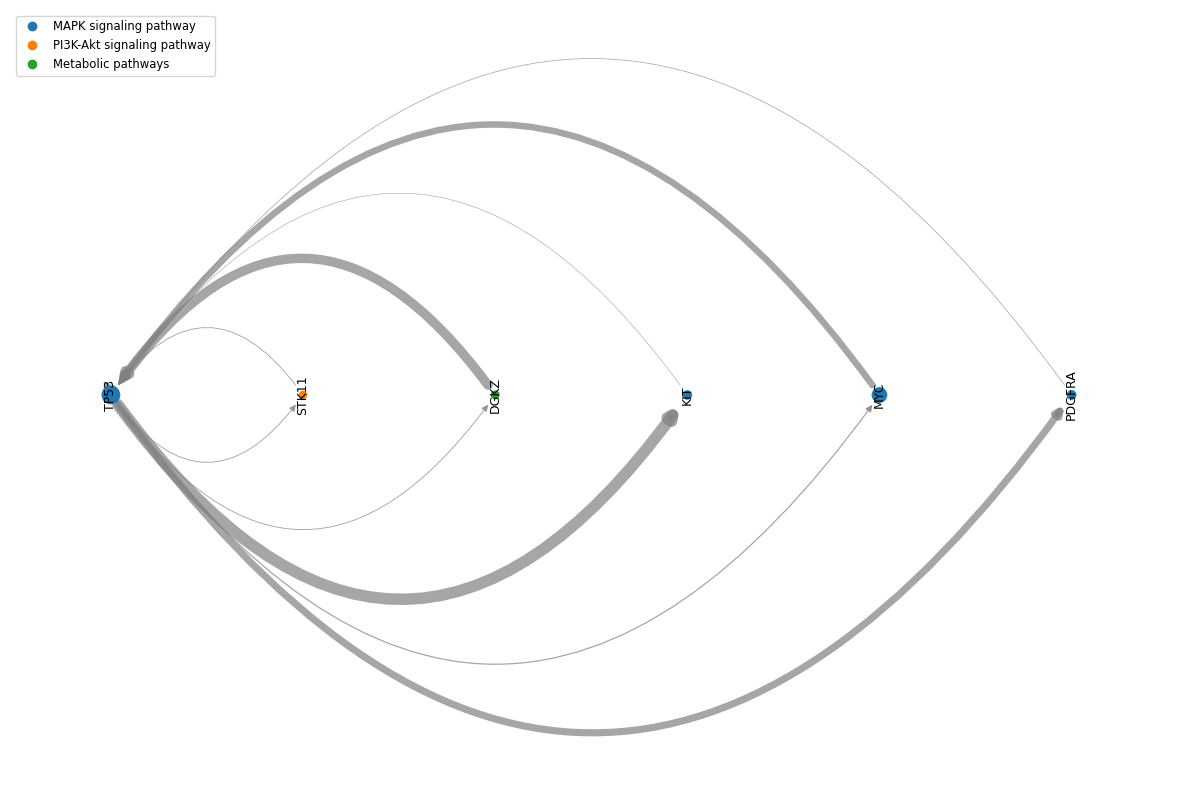

In [86]:
plot_cell_line_graph('CVCL_1195', node_importance, data1195, 
    gene_list = sel_genes['related_genes'][sel_genes['cellosaurus_id'] == 'CVCL_1195'].values[0].split(', '))

In [87]:
# Example usage 
gene_names = att_df['p2_name'][att_df['cell'] == 'CVCL_1331'].unique().tolist()
processes1331 = retrieve_kegg_biological_processes(gene_names, 'CVCL_1331')
df1331 = prepare_df(processes1331)
data1331 = prepare_cell_line_data(df1331, att_df, 'CVCL_1331', node_importance)
data1331.drop_duplicates(inplace = True)

In [88]:
data1331[data1331['gene_name'].isin(['APC', 'BRAF', 'KRAS', 'TP53', 'MYC', 'BCL10', 'BUB1', 'FGFR4', 'ING2',
                                      'PDZK1IP1', 'PTPN12', 'PTPRJ', 'RAD54B'])]

,attention,protein_1,protein_2,cell,p1_name,p2_name,gene_name,biological_processes,node,node_importance
6,0.021175,678,2429,CVCL_1331,DVL2,TP53,TP53,Wnt signaling pathway,TP53,0.004080
8,0.138092,678,138,CVCL_1331,DVL2,APC,APC,Wnt signaling pathway,APC,0.000410
47,0.020623,2085,2429,CVCL_1331,SIRT1,TP53,TP53,Wnt signaling pathway,TP53,0.004080
90,0.015825,545,2429,CVCL_1331,CYP24A1,TP53,TP53,Wnt signaling pathway,TP53,0.004080
126,0.150024,526,138,CVCL_1331,CSNK2A1,APC,APC,Wnt signaling pathway,APC,0.000410
...,...,...,...,...,...,...,...,...,...,...
3259,0.015440,971,2429,CVCL_1331,GRIN2B,TP53,TP53,Wnt signaling pathway,TP53,0.004080
3317,0.124019,138,138,CVCL_1331,APC,APC,APC,Wnt signaling pathway,APC,0.000410
3340,0.461448,235,235,CVCL_1331,BCL10,BCL10,BCL10,NF-kappa B signaling pathway,BCL10,0.000335
3348,0.187114,262,262,CVCL_1331,BRAF,BRAF,BRAF,FoxO signaling pathway,BRAF,0.002050


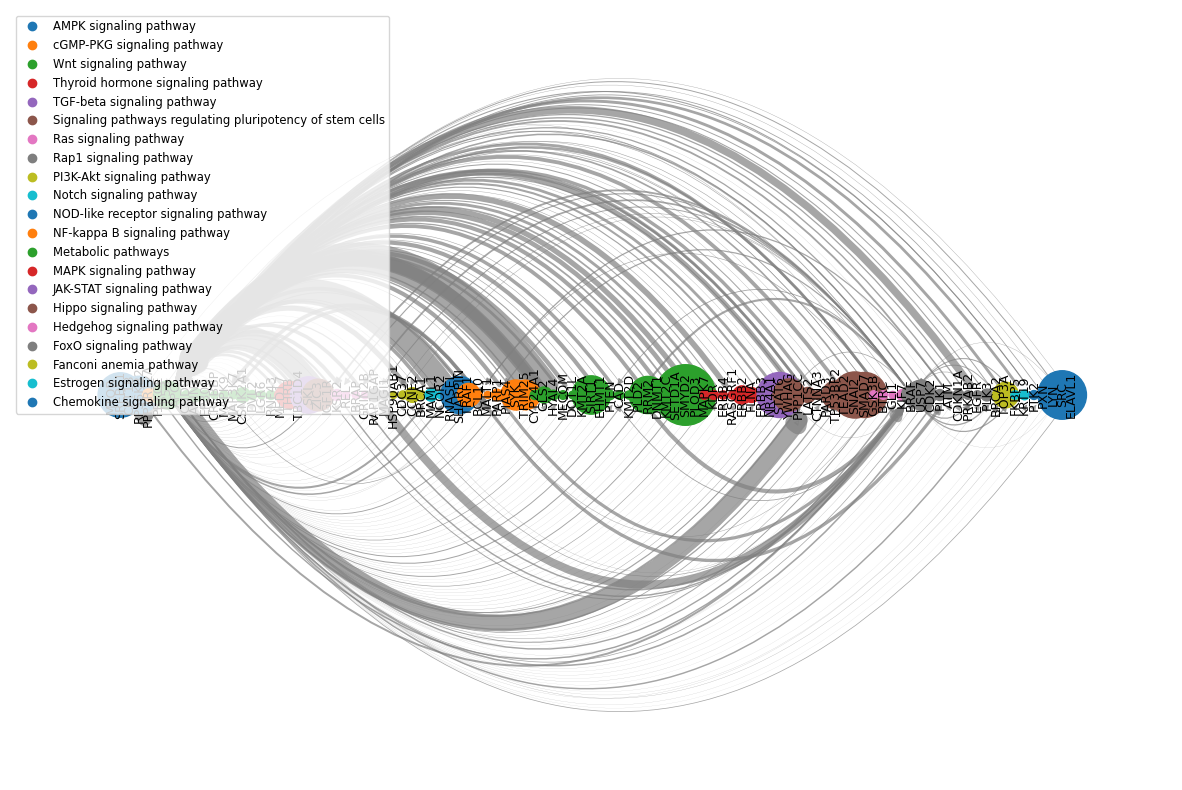

In [89]:
plot_cell_line_graph('CVCL_1331', node_importance, data1331, 
    gene_list =['APC', 'BRAF', 'KRAS', 'TP53', 'MYC', 'BCL10', 'BUB1', 'FGFR4', 'ING2',
                                      'PDZK1IP1', 'PTPN12', 'PTPRJ', 'RAD54B'])